In [1]:
from typing import Literal
from enum import Enum
import time
from pathlib import Path
import numpy as np
import pandas as pd

from transitions.extensions import GraphMachine as Machine
import transitions as tr
from IPython.display import Image
from mermaid import Mermaid
from loguru import logger

from models_psa.utils.fsms import test_state

%load_ext autoreload

%autoreload 2

In [2]:
# States definition

class SolarFieldState(Enum):
    IDLE = 0
    ACTIVE = 1
    
class ThermalStorageState(Enum):
    IDLE = 0
    ACTIVE = 1

class MedVacuumState(Enum):
    OFF = 0
    LOW = 1
    HIGH = 2

class MedState(Enum):
    OFF = 0
    GENERATING_VACUUM = 1
    IDLE = 2
    STARTING_UP = 3
    SHUTTING_DOWN = 4
    ACTIVE = 5

# class MedOperatingModes(Enum):
#     """ 
#     Extends the MEDState enum to include transient states 
#     """
#     OFF = 0
#     GENERATING_VACUUM = 1
#     IDLE = 2
#     ACTIVE = 3
#     STARTING_UP = 4
#     SHUTTING_DOWN = 5

# Programatic names
# SF_TS_State = Enum('SF_TS_State', {
#     f'sf_{sf_state.name}-ts_{ts_state.name}': f'{sf_state.value}{ts_state.value}'
#     for sf_state in SolarFieldState
#     for ts_state in ThermalStorageState
# })

# More descriptive manually typed names
class SF_TS_State(Enum):
    IDLE = '00'
    RECIRCULATING_TS = '01'
    HEATING_UP_SF = '10'
    SF_HEATING_TS = '11'

SolarMED_State = Enum('SolarMED_State', {
    f'sf_{sf_state.name}-ts_{ts_state.name}-med_{med_state.name}': f'{sf_state.value}{ts_state.value}{med_state.value}'
    for sf_state in SolarFieldState
    for ts_state in ThermalStorageState
    for med_state in MedState
})

states_sf_ts = [state for state in SF_TS_State]
states_med = [state for state in MedState]

print("SOLAR MED STATES")
for state in SolarMED_State:
    print(f"{state.name}: {state.value}")
    
print("\nMED STATES")
for state in MedState:
    print(f"{state.name}: {state.value}")
    
print("\nSOLAR FIELD - THERMAL STORAGE STATES")
for state in SF_TS_State:
    print(f"{state.name}: {state.value}")

SOLAR MED STATES
sf_IDLE-ts_IDLE-med_OFF: 000
sf_IDLE-ts_IDLE-med_GENERATING_VACUUM: 001
sf_IDLE-ts_IDLE-med_IDLE: 002
sf_IDLE-ts_IDLE-med_STARTING_UP: 003
sf_IDLE-ts_IDLE-med_SHUTTING_DOWN: 004
sf_IDLE-ts_IDLE-med_ACTIVE: 005
sf_IDLE-ts_ACTIVE-med_OFF: 010
sf_IDLE-ts_ACTIVE-med_GENERATING_VACUUM: 011
sf_IDLE-ts_ACTIVE-med_IDLE: 012
sf_IDLE-ts_ACTIVE-med_STARTING_UP: 013
sf_IDLE-ts_ACTIVE-med_SHUTTING_DOWN: 014
sf_IDLE-ts_ACTIVE-med_ACTIVE: 015
sf_ACTIVE-ts_IDLE-med_OFF: 100
sf_ACTIVE-ts_IDLE-med_GENERATING_VACUUM: 101
sf_ACTIVE-ts_IDLE-med_IDLE: 102
sf_ACTIVE-ts_IDLE-med_STARTING_UP: 103
sf_ACTIVE-ts_IDLE-med_SHUTTING_DOWN: 104
sf_ACTIVE-ts_IDLE-med_ACTIVE: 105
sf_ACTIVE-ts_ACTIVE-med_OFF: 110
sf_ACTIVE-ts_ACTIVE-med_GENERATING_VACUUM: 111
sf_ACTIVE-ts_ACTIVE-med_IDLE: 112
sf_ACTIVE-ts_ACTIVE-med_STARTING_UP: 113
sf_ACTIVE-ts_ACTIVE-med_SHUTTING_DOWN: 114
sf_ACTIVE-ts_ACTIVE-med_ACTIVE: 115

MED STATES
OFF: 0
GENERATING_VACUUM: 1
IDLE: 2
STARTING_UP: 3
SHUTTING_DOWN: 4
ACTIVE: 5

SOLA

In [2]:
valid_input = 1.0
invalid_input = 0.0

## MED FSM

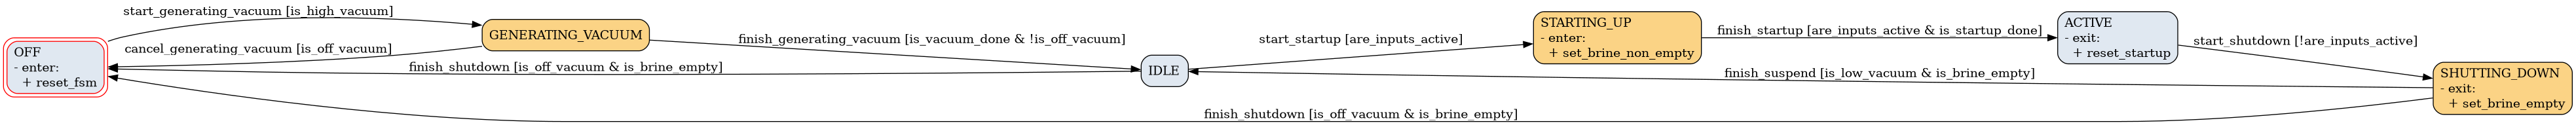

In [3]:
class MedFSM:
    
    sample_rate: int = 1  # seconds
    current_sample = 0
    
    # Vacuum
    generating_vacuum: bool = False
    vacuum_generated: bool = False
    vacuum_duration_time: int = 5 # seconds
    vacuum_started_sample = None
    
    # Shutdown
    brine_empty = True
    brine_emptying_time: float = 1 # seconds
    brine_emptying_started_sample = None
    
    # Startup
    startup_done: bool = False
    startup_duration_time: int = 2 # seconds
    startup_started_sample = None
    
    # Inputs / Decision variables
    mmed_s: float = 0
    mmed_f: float = 0
    Tmed_s_in: float = 0
    Tmed_c_out: float = 0
    med_vacuum_state: MedVacuumState = MedVacuumState.OFF
    
    
    def __init__(self, name:str = "MED_FSM", initial_state:MedState = MedState.OFF):
        
        self.name = name
        self.vacuum_duration_samples = int(self.vacuum_duration_time / self.sample_rate)
        self.brine_emptying_samples = int(self.brine_emptying_time / self.sample_rate)
        self.startup_duration_samples = int(self.startup_duration_time / self.sample_rate)
        
        if initial_state in [MedState.ACTIVE, MedState.STARTING_UP]:
            self.brine_empty = False

        self.machine = Machine(
            model=self, initial=initial_state, auto_transitions=False, show_conditions=True, show_state_attributes=True,
            ignore_invalid_triggers=False, queued=True, send_event=True, #finalize_event=''
            before_state_change='inform_exit_state', after_state_change='inform_enter_state',
        )
        
        # States
        # OFF = 0
        # IDLE = 1
        # ACTIVE = 2
        st = MedState
        
        self.machine.add_state(st.OFF, on_enter=['reset_fsm'])
        self.machine.add_state(st.GENERATING_VACUUM)
        self.machine.add_state(st.IDLE)
        self.machine.add_state(st.STARTING_UP, on_enter=['set_brine_non_empty'])
        self.machine.add_state(st.ACTIVE, on_exit=['reset_startup'])
        self.machine.add_state(st.SHUTTING_DOWN, on_exit=['set_brine_empty'])
        
        # Transitions
        # {'trigger': 'generate_vacuum', 'source': 'OFF', 'dest': 'IDLE'},
        # {'trigger': 'start_up', 'source': 'IDLE', 'dest': 'ACTIVE'},
        # {'trigger': 'suspend', 'source': 'ACTIVE', 'dest': 'IDLE'},
        # {'trigger': 'complete_shut_off', 'source': 'ACTIVE', 'dest': 'OFF'},
        # {'trigger': 'partial_shut_off', 'source': 'IDLE', 'dest': 'OFF'},
        
        # Vacuum
        self.machine.add_transition('start_generating_vacuum',  source=st.OFF, dest=st.GENERATING_VACUUM, conditions=['is_high_vacuum'], after='set_vacuum_start')
        self.machine.add_transition('finish_generating_vacuum', source= st.GENERATING_VACUUM, dest=st.IDLE, conditions=['is_vacuum_done'], unless=['is_off_vacuum'], after='set_vacuum_done')
        self.machine.add_transition('cancel_generating_vacuum', source= st.GENERATING_VACUUM, dest=st.OFF, conditions=['is_off_vacuum'])
        
        # Start-up
        self.machine.add_transition('start_startup', source=st.IDLE, dest=st.STARTING_UP, conditions=['are_inputs_active'], after='set_startup_start')
        self.machine.add_transition('finish_startup', source=st.STARTING_UP, dest=st.ACTIVE, conditions=['are_inputs_active', 'is_startup_done'], after='set_startup_done')
        
        # Shutdown
        self.machine.add_transition('start_shutdown', source=st.ACTIVE, dest=st.SHUTTING_DOWN, unless=['are_inputs_active'], after='set_brine_emptying_start')
        self.machine.add_transition('finish_shutdown', source=[st.SHUTTING_DOWN, st.IDLE], dest=st.OFF, conditions=['is_off_vacuum', 'is_brine_empty']) # Since destination is OFF already resets FSM
        self.machine.add_transition('finish_suspend', source=st.SHUTTING_DOWN, dest=st.IDLE, conditions=['is_low_vacuum', 'is_brine_empty'], after='set_brine_empty')
                
        self.customize_fsm_style()
                
    def customize_fsm_style(self):
        # Custom styling of state machine graph
        self.machine.machine_attributes['ratio'] = '0.5'
        # self.machine.machine_attributes['rankdir'] = 'TB'
        self.machine.style_attributes['node']['transient'] = {'fillcolor': '#FBD385'}
        self.machine.style_attributes['node']['steady'] = {'fillcolor': '#E0E8F1'}
        
        # customize node styling
        model_ = list(self.machine.model_graphs.keys())[0] # lavin
        for s in [MedState.GENERATING_VACUUM, MedState.STARTING_UP, MedState.SHUTTING_DOWN]:
            self.machine.model_graphs[model_].set_node_style(s, 'transient')
        for s in [MedState.OFF, MedState.IDLE, MedState.ACTIVE]:
            self.machine.model_graphs[model_].set_node_style(s, 'steady')
        
        
    # State machine actions - callbacks of states and transitions
    def inform_enter_state(self, *args):
        
        event = args[0]
        
        # Inform of not invalid but wasteful operations
        if self.vacuum_generated == True and self.is_high_vacuum():
            logger.warning("Vacuum already generated, keeping vacuum at high value is wasteful")
        if event.state == MedState.OFF and self.is_low_vacuum():
            logger.warning("MED vacuum state is OFF, vacuum should be off or high to start generating vacuum")
        if event.state in [MedState.SHUTTING_DOWN, MedState.IDLE, MedState.OFF] and self.are_inputs_valid():
            logger.warning("MED is not operating, there is no point in having its inputs active")
        
        logger.debug(f"Entered state {event.state.name}")
        
    def inform_exit_state(self, *args):
        event = args[0]
        logger.debug(f"Left state {event.state.name}")
    
    def reset_fsm(self, *args):
        logger.info(f"Resetting {self.name} FSM")
        self.set_vacuum_reset()
        # self.set_brine_empty()
        # self.reset_startup()
        # Anything else?
        

    # Vacuum
    def set_vacuum_start(self, *args):
        if self.generating_vacuum:
            logger.warning("Already generating vacuum, no need to start again")
            return
        
        # Else
        self.vacuum_started_sample = self.current_sample
        logger.info(f"Started generating vacuum, it will take {self.vacuum_duration_samples} samples to complete")
        
    def set_vacuum_reset(self, *args):
        self.vacuum_started_sample = None
        logger.info("Cancelled vacuum generation")
        
    def set_vacuum_done(self, *args):
        self.vacuum_generated = True
        logger.info("Vacuum generated")
        
    # Shutdown
    def set_brine_emptying_start(self, *args):
        if self.brine_empty:
            logger.warning("Brine is already empty, no need to start emptying again")
            return
        
        self.brine_emptying_started_sample = self.current_sample
        logger.info(f"Started emptying brine, it will take {self.brine_emptying_samples} samples to complete")
        
    def set_brine_empty(self, *args):
        self.brine_empty = True
        self.brine_emptying_started_sample = None
        logger.info("Brine emptied")
        
    def set_brine_non_empty(self, *args):
        self.brine_empty = False
        logger.info("Brine non-empty")
        
        
    # Startup
    def set_startup_start(self, *args):
        if self.startup_done:
            logger.warning("Startup already done, no need to start again")
            return
        
        self.startup_started_sample = self.current_sample
        logger.info(f"Started starting up, it will take {self.startup_duration_samples} samples to complete")

    def set_startup_done(self, *args):
        self.startup_done = True
        logger.info("Startup done")
        
    def reset_startup(self, *args):
        self.startup_done = False
        self.startup_started_sample = None
        logger.info("Startup reset")
            
    # State machine transition conditions
    # Vacuum
    def is_high_vacuum(self, *args): #, raise_error: bool = False):
        return self.med_vacuum_state == MedVacuumState.HIGH

    def is_low_vacuum(self, *args):
        return self.med_vacuum_state == MedVacuumState.LOW
    
    def is_off_vacuum(self, *args):
        return self.med_vacuum_state == MedVacuumState.OFF
    
    def is_vacuum_done(self, *args):
        if self.vacuum_generated:
            return True
        
        if self.current_sample - self.vacuum_started_sample >= self.vacuum_duration_samples:
            return True
        else:
            logger.info(f"Still generating vacuum, {self.current_sample - self.vacuum_started_sample}/{self.vacuum_duration_samples} samples completed")
            return False
    
    # Startup
    def is_startup_done(self, *args):
        if self.startup_done:
            return True
        
        if self.current_sample - self.startup_started_sample >= self.startup_duration_samples:
            return True
        else:
            logger.info(f"Still starting up, {self.current_sample - self.startup_started_sample}/{self.startup_duration_samples} samples completed")
            return False

    # Shutdown
    def is_brine_empty(self, *args):
        if self.brine_empty: 
            return True
        
        if self.current_sample - self.brine_emptying_started_sample >= self.brine_emptying_samples:
            return True
        else:
            logger.info(f"Still emptying brine, {self.current_sample - self.brine_emptying_started_sample}/{self.brine_emptying_samples} samples completed")
            return False

    def are_inputs_valid(self, *args):
        # Just check if the inputs are greater than zero, not the vacuum
        return np.all(np.array( [self.mmed_s, self.mmed_f, self.Tmed_s_in, self.Tmed_c_out] ) > 0)
    
    def are_inputs_active(self, *args): # inputs: list[float] | np.ndarray = np.array([0])
        # Checks if all variables required for MED to active are valid (greater than zero and vacuum active)        
        # inputs = np.array( event.kwargs.get('inputs', 0) )
        
        return self.are_inputs_valid() and self.med_vacuum_state != MedVacuumState.OFF
            
        # else:
        #     logger.warning("MED inputs are not valid, all values should be greater than zero")
        #     return False
        
    def step(self, mmed_s: float, mmed_f: float, Tmed_s_in: float, Tmed_c_out: float, med_vacuum_state: int | MedVacuumState):
        
        self.current_sample += 1
        
        # Inputs validation (would be done by Pydantic), here just update the values
        self.mmed_s = mmed_s
        self.mmed_f = mmed_f
        self.Tmed_s_in = Tmed_s_in
        self.Tmed_c_out = Tmed_c_out
        
        self.med_vacuum_state = MedVacuumState(med_vacuum_state)
        # MED_inputs_gt_zero = np.all([mmed_s, mmed_f, Tmed_s_in, Tmed_c_out])
        # 
        # if MED_vac_state == MedVacuumState.OFF:
        #     if MED_inputs_gt_zero:
        #         logger.warning("Vacuum is OFF, ignoring other MED inputs")
        #     transition_trigger_id = 'to_OFF'
        #     
        # elif MED_vac_state == MedVacuumState.HIGH:
        #     if MED_inputs_gt_zero:
        #         logger.warning("Vacuum is HIGH (being generated), ignoring other MED inputs")
        #     # self.machine.to_IDLE()
        #     transition_trigger_id = 'to_IDLE'
        #     
        # elif MED_vac_state == MedVacuumState.LOW:
        #     if MED_inputs_gt_zero:
        #         # self.machine.to_ACTIVE()
        #         transition_trigger_id = 'to_ACTIVE'
        #     else:
        #         # self.machine.to_IDLE()
        #         # if self.state == MedState.OFF:
        #         #     raise ValueError("MED vacuum state is LOW, but the MED is OFF, only HIGH is valid to start generating vacuum")
        #         transition_trigger_id = 'to_IDLE'
        # else:
        #     raise ValueError("Invalid MED vacuum state")
        # 
        # logger.info(f"Transitioning {transition_trigger_id}")

        # Check every transition possible from the current state
        # There could be several
        candidate_transitions = self.machine.get_triggers(self.state)
        # However, when checking if the transition is valid, only one should be valid
        transition_trigger_id = None
        for candidate in candidate_transitions:
            check_id = f'may_{candidate}'
            check_transition = getattr(self, check_id)
            if check_transition():
                if transition_trigger_id is not None:
                    raise ValueError("WDYM More than one transition is valid")
                
                transition_trigger_id = candidate
                
        if transition_trigger_id is None:
            logger.info(f"No valid transition found from state {self.state} out of candidates {candidate_transitions}, staying in {self.state}")
            return

        transition = getattr(self, transition_trigger_id)
        transition()


model = MedFSM()  
result = model.machine.get_graph().draw(None, format="png", prog='dot'); display(Image(result))

# Compare with manual diagram
Mermaid(
    """
    graph TB
    n1(["0 - OFF"])
    n2(["1 - Generating vacuum"])
    n3(["2 - Idle"])
    n4(["3 - Starting up"])
    n5(["4 - Active"])
    n6(["5 - Shutting down"])
    n1 <--> n2
    n2 --> n3
    n3 --> n1
    n3 --> n4
    n4 --> n5
    n5 --> n6
    n6 --> n1
    n6 --> n3
    """
)

In [4]:
# Save diagram to results/diagrams

fmt = 'svg'
with open(Path('results/diagrams') / f'{model.name}.{fmt}', 'bw') as f:
    # you need to pass the format when you pass objects instead of filenames.
    model.get_graph().draw(f, format=fmt, prog='dot')
    
    logger.info(f'Saved diagram to results/diagrams/{model.name}.{fmt}')

2024-04-12 11:35:29.433 | INFO     | __main__:<module>:8 - Saved diagram to results/diagrams/MED_FSM.svg


### Test the MED class

In [15]:
# Either use the class defined here
# Or import it from the package

from solarMED_optimization.fsm import MedFSM, MedState, MedVacuumState

2024-04-15 14:56:11.084 | DEBUG    | solarMED_optimization.fsm:inform_exit_state:63 - Left state OFF
2024-04-15 14:56:11.085 | INFO     | solarMED_optimization.fsm:set_vacuum_start:352 - Started generating vacuum, it will take 5 samples to complete
2024-04-15 14:56:11.085 | DEBUG    | solarMED_optimization.fsm:inform_enter_state:59 - Entered state GENERATING_VACUUM
2024-04-15 14:56:11.086 | INFO     | solarMED_optimization.fsm:is_vacuum_done:416 - Still generating vacuum, 1/5 samples completed
2024-04-15 14:56:11.087 | DEBUG    | solarMED_optimization.fsm:inform_exit_state:63 - Left state GENERATING_VACUUM
2024-04-15 14:56:11.087 | INFO     | solarMED_optimization.fsm:reset_fsm:338 - Resetting MED_FSM FSM
2024-04-15 14:56:11.088 | INFO     | solarMED_optimization.fsm:set_vacuum_reset:356 - Cancelled vacuum generation
2024-04-15 14:56:11.088 | DEBUG    | solarMED_optimization.fsm:inform_enter_state:59 - Entered state OFF
2024-04-15 14:56:11.089 | INFO     | solarMED_optimization.fsm:get

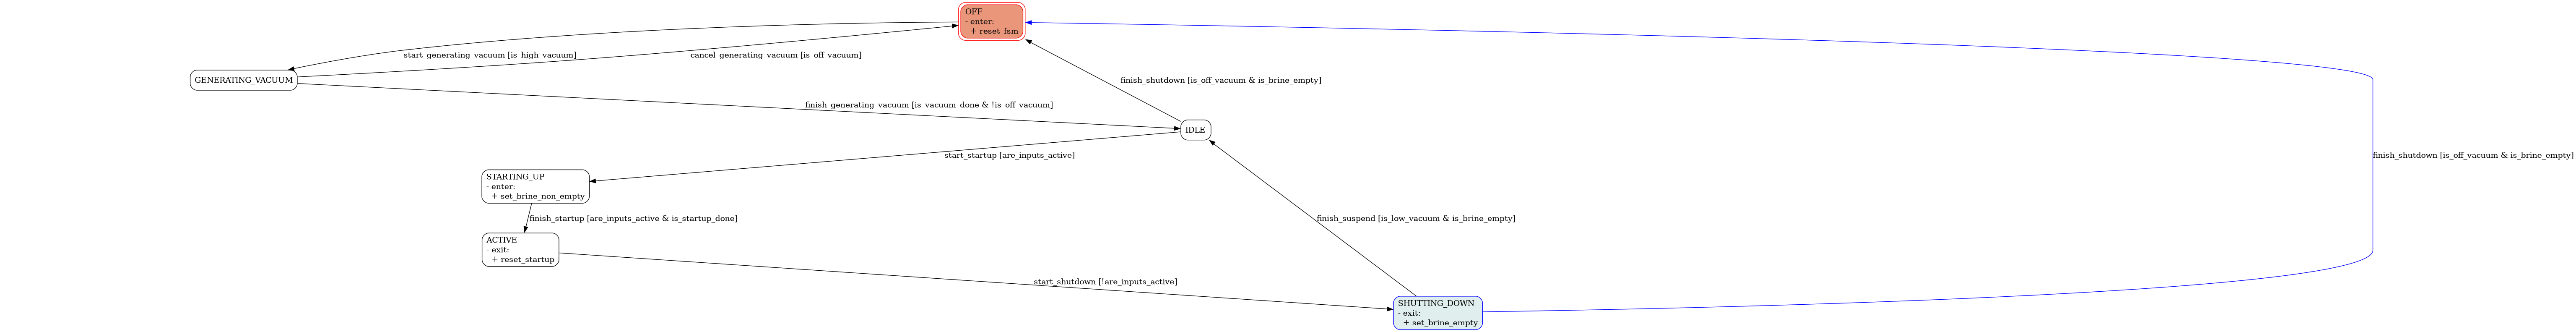

In [16]:
# Test the MED class
model = MedFSM()

# Go from OFF to GENERATING_VACUUM and cancel it
model.step(mmed_s=valid_input, mmed_f=valid_input, Tmed_s_in=valid_input, Tmed_c_out=valid_input, med_vacuum_state=MedVacuumState.HIGH)
test_state(test_state='GENERATING_VACUUM', base_cls=MedState, model=model)
model.step(mmed_s=valid_input, mmed_f=valid_input, Tmed_s_in=valid_input, Tmed_c_out=valid_input, med_vacuum_state=MedVacuumState.OFF)
test_state(test_state='OFF', base_cls=MedState, model=model)

# Go from OFF to IDLE
model.step(mmed_s=valid_input, mmed_f=valid_input, Tmed_s_in=valid_input, Tmed_c_out=valid_input, med_vacuum_state=MedVacuumState.LOW)
while model.state != MedState.IDLE:
    model.step(mmed_s=valid_input, mmed_f=valid_input, Tmed_s_in=valid_input, Tmed_c_out=1, med_vacuum_state=MedVacuumState.HIGH)
    time.sleep(1)
test_state(test_state='IDLE', base_cls=MedState, model=model)    

# Go from IDLE to ACTIVE
while model.state != MedState.ACTIVE:
    model.step(mmed_s=valid_input, mmed_f=valid_input, Tmed_s_in=valid_input, Tmed_c_out=valid_input, med_vacuum_state=MedVacuumState.LOW)
    time.sleep(1)
test_state(test_state='ACTIVE', base_cls=MedState, model=model)

# Go from ACTIVE to IDLE
while model.state != MedState.IDLE:
    model.step(mmed_s=invalid_input, mmed_f=valid_input, Tmed_s_in=valid_input, Tmed_c_out=valid_input, med_vacuum_state=MedVacuumState.LOW)
    time.sleep(1)
test_state(test_state='IDLE', base_cls=MedState, model=model)

# Go back to ACTIVE
while model.state != MedState.ACTIVE:
    model.step(mmed_s=valid_input, mmed_f=valid_input, Tmed_s_in=valid_input, Tmed_c_out=valid_input, med_vacuum_state=MedVacuumState.LOW)
    time.sleep(1)
test_state(test_state='ACTIVE', base_cls=MedState, model=model)

# Go to OFF
while model.state != MedState.OFF:
    model.step(mmed_s=valid_input, mmed_f=valid_input, Tmed_s_in=valid_input, Tmed_c_out=valid_input, med_vacuum_state=MedVacuumState.OFF)
    time.sleep(1)
test_state(test_state='OFF', base_cls=MedState, model=model)


result = model.machine.get_graph().draw(None, format="png", prog='dot'); display(Image(result))

## Solar Field with Thermal Storage FSM

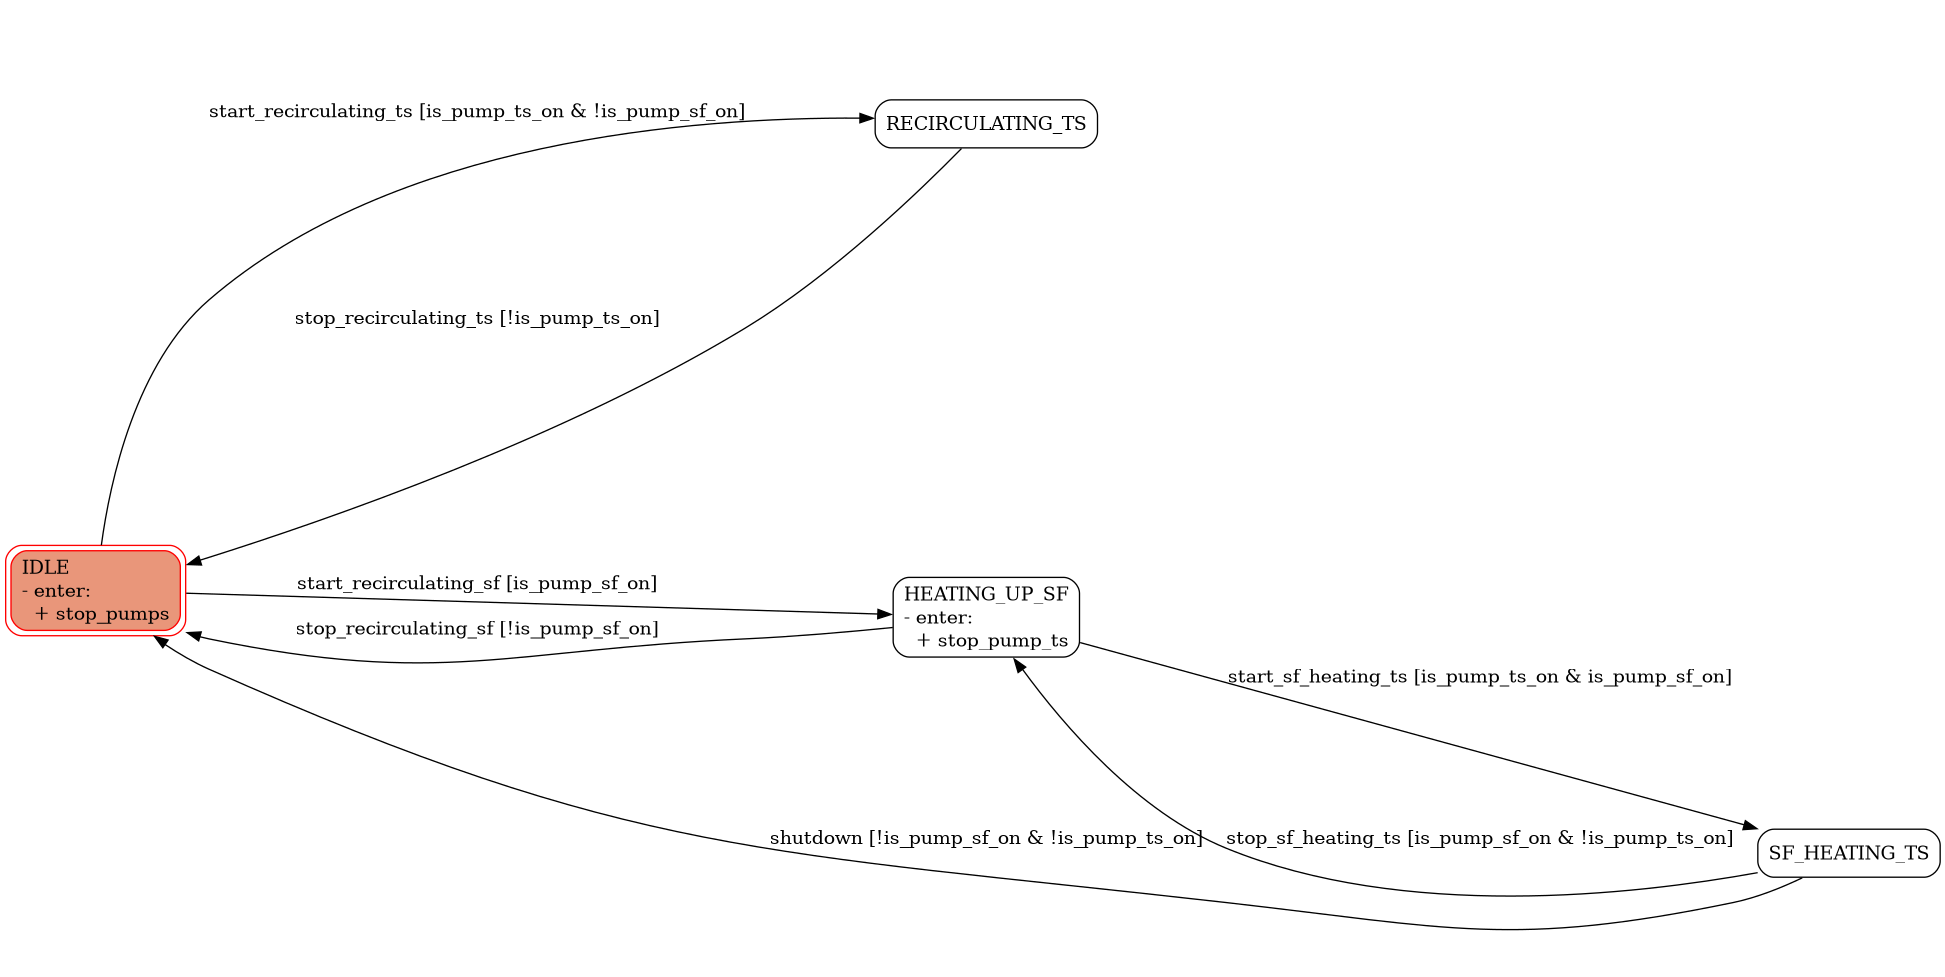

In [6]:
class SolarFieldWithThermalStorage_FSM:
    
    sample_rate: int = 1  # seconds
    current_sample = 0
    
    # Inputs / Decision variables
    qsf: float = 0
    qts_src: float = 0
    
    
    def __init__(self, name:str = "SF-TS_FSM", initial_state:SF_TS_State = SF_TS_State.IDLE):
        
        self.name = name
        st = SF_TS_State # alias
        
        # Initialize prior values
        self.qsf_prior = self.qsf
        self.qts_src_prior = self.qts_src

        # State machine initialization
        self.machine = Machine(
            model=self, initial=initial_state, auto_transitions=False, show_conditions=True, show_state_attributes=True,
            ignore_invalid_triggers=False, queued=True, send_event=True, #finalize_event=''
            before_state_change='inform_exit_state', after_state_change='inform_enter_state',
        )
        
        # States
        self.machine.add_state(st.IDLE, on_enter=['stop_pumps'])
        self.machine.add_state(st.RECIRCULATING_TS)
        self.machine.add_state(st.HEATING_UP_SF, on_enter=['stop_pump_ts'])
        self.machine.add_state(st.SF_HEATING_TS)
        
        # Transitions
        self.machine.add_transition('start_recirculating_ts',  source=st.IDLE, dest=st.RECIRCULATING_TS, conditions=['is_pump_ts_on'], unless=['is_pump_sf_on'])
        self.machine.add_transition('stop_recirculating_ts', source=st.RECIRCULATING_TS, dest=st.IDLE, unless=['is_pump_ts_on'])
        
        self.machine.add_transition('start_recirculating_sf', source=st.IDLE, dest=st.HEATING_UP_SF, conditions=['is_pump_sf_on'])
        self.machine.add_transition('stop_recirculating_sf', source=st.HEATING_UP_SF, dest=st.IDLE, unless=['is_pump_sf_on'])
        self.machine.add_transition('start_sf_heating_ts', source=st.HEATING_UP_SF, dest=st.SF_HEATING_TS, conditions=['is_pump_ts_on', 'is_pump_sf_on'])
        
        self.machine.add_transition('stop_sf_heating_ts', source=st.SF_HEATING_TS, dest=st.HEATING_UP_SF, conditions=['is_pump_sf_on'], unless=['is_pump_ts_on'])
        self.machine.add_transition('shutdown', source=st.SF_HEATING_TS, dest=st.IDLE, unless=['is_pump_sf_on', 'is_pump_ts_on'])


        # Additional
        self.customize_fsm_style()
                
    def customize_fsm_style(self):
        # Custom styling of state machine graph
        self.machine.machine_attributes['ratio'] = '0.5'
        self.machine.machine_attributes['rankdir'] = 'TB'
        
        
    # State machine actions - callbacks of states and transitions
    def inform_enter_state(self, *args):
        
        event = args[0]
        
        # Inform of not invalid but wasteful operations
        # ...
        
        logger.debug(f"Entered state {event.state.name}")
        
    def inform_exit_state(self, *args):
        event = args[0]
        logger.debug(f"Left state {event.state.name}")
    
        
    def stop_pump_ts(self, *args):
        self.qts_src = 0
        
    def stop_pump_sf(self, *args):
        self.qsf = 0
        
    def stop_pumps(self, *args):
        logger.info("Stopping pumps")
        self.stop_pump_ts()
        self.stop_pump_sf()
            
    # State machine transition conditions
    # Solar field
    def is_pump_sf_on(self, *args):
        return self.qsf > 0
    
    # Thermal storage
    def is_pump_ts_on(self, *args):
        return self.qts_src > 0
    
        
    def step(self, qsf: float, qts_src: float):
        
        self.current_sample += 1
        
        # Inputs validation (would be done by Pydantic), here just update the values
        self.qsf = qsf
        self.qts_src = qts_src

        # Check every transition possible from the current state
        # There could be several
        candidate_transitions = self.machine.get_triggers(self.state)
        # However, when checking if the transition is valid, only one should be valid
        transition_trigger_id = None
        for candidate in candidate_transitions:
            check_id = f'may_{candidate}'
            check_transition = getattr(self, check_id)
            if check_transition():
                if transition_trigger_id is not None:
                    raise ValueError("WDYM More than one transition is valid")
                
                transition_trigger_id = candidate
                
        if transition_trigger_id is None:
            if self.qsf_prior != self.qsf or self.qts_src_prior != self.qts_src:
                # Inputs changed, yet no valid transition, raise error
                raise tr.MachineError(f"No valid transition for given inputs {qsf, qts_src} from state {self.state}")
            else:
                logger.info("Inputs are the same from prior iteration, no transition needed")
                
            return

        transition = getattr(self, transition_trigger_id)
        transition()
        
        # Save prior inputs
        self.qsf_prior = qsf
        self.qts_src_prior = qts_src
        
        self.calculate_consumptions()
        
    # Auxiliary methods (to calculate associated costs depending on the state)
    def generate_graph(self, fmt:Literal['png', 'svg'] = 'svg', output_path:Path = None):
        if output_path is not None:
            # Create output directory if it doesn't exist
            output_path.parent.mkdir(parents=True, exist_ok=True)
            
            with open(output_path, 'bw') as f:
                return self.machine.get_graph().draw(f, format=fmt, prog='dot')
        else:
            return self.machine.get_graph().draw(None, format=fmt, prog='dot')
    
    def calculate_consumptions(self):
        # Calculate the consumption of the solar field and thermal storage
        
        """ This method should only be called after the state is updated, so that the flows reflect the correct state """
        
        self.Jsf = 0.5 * self.qsf**2
        self.Jts = 0.5 * self.qts_src**2
        self.Jtotal = self.Jsf + self.Jts
    
    def to_dataframe(self, df:pd.DataFrame = None):
        # Return some of the internal variables as a dataframe
        # the state as en Enum?str?, the inputs, the consumptions

        if df is None:
            df = pd.DataFrame()
            
        data = pd.DataFrame({
            'state': self.state.name,
            'qsf': self.qsf,
            'qts_src': self.qts_src,
            'Jsf': self.Jsf,
            'Jts': self.Jts,
            'Jtotal': self.Jtotal,
        })
        
        df = pd.concat([df, data], ignore_index=True)
        
        return df
        
        
    
model = SolarFieldWithThermalStorage_FSM()
result = model.get_graph().draw(None, format="png", prog='dot'); display(Image(result))

Mermaid(
    """
    graph TB
    n1(["00 - Idle"])
    n2(["01 - Recirculating th. storage"])
    n3(["10 - Heating up solar field"])
    n4(["11 - Solar field heating th. storage"])

    n1 <--> n3
    n1 <--> n2
    n3 <--> n4
    n4 --> n1
    """
)

In [7]:
# Save diagram to results/diagrams

fmt = 'svg'
with open(Path('results/diagrams') / f'{model.name}.{fmt}', 'bw') as f:
    # you need to pass the format when you pass objects instead of filenames.
    model.get_graph().draw(f, format=fmt, prog='dot')
    
    logger.info(f'Saved diagram to results/diagrams/{model.name}.{fmt}')

2024-04-12 11:35:46.072 | INFO     | __main__:<module>:8 - Saved diagram to results/diagrams/SF-TS_FSM.svg


### Test the Solar Field with Thermal Storage class

In [3]:
# Either use the class defined here
# Or import it from the package

from solarMED_optimization.fsm import SolarFieldWithThermalStorage_FSM, SF_TS_State

2024-04-15 14:38:28.215 | DEBUG    | solarMED_optimization.fsm:inform_exit_state:65 - Left state IDLE
2024-04-15 14:38:28.216 | DEBUG    | solarMED_optimization.fsm:inform_enter_state:61 - Entered state RECIRCULATING_TS
2024-04-15 14:38:28.217 | INFO     | __main__:<module>:16 - Expected error: 'No valid transition for given inputs [1 1] from state SF_TS_State.RECIRCULATING_TS'
2024-04-15 14:38:28.218 | DEBUG    | solarMED_optimization.fsm:inform_exit_state:65 - Left state RECIRCULATING_TS
2024-04-15 14:38:28.219 | INFO     | solarMED_optimization.fsm:stop_pumps:163 - Stopping pumps
2024-04-15 14:38:28.220 | DEBUG    | solarMED_optimization.fsm:inform_enter_state:61 - Entered state IDLE
2024-04-15 14:38:28.221 | DEBUG    | solarMED_optimization.fsm:inform_exit_state:65 - Left state IDLE
2024-04-15 14:38:28.223 | DEBUG    | solarMED_optimization.fsm:inform_enter_state:61 - Entered state HEATING_UP_SF
2024-04-15 14:38:28.223 | DEBUG    | solarMED_optimization.fsm:inform_exit_state:65 - L

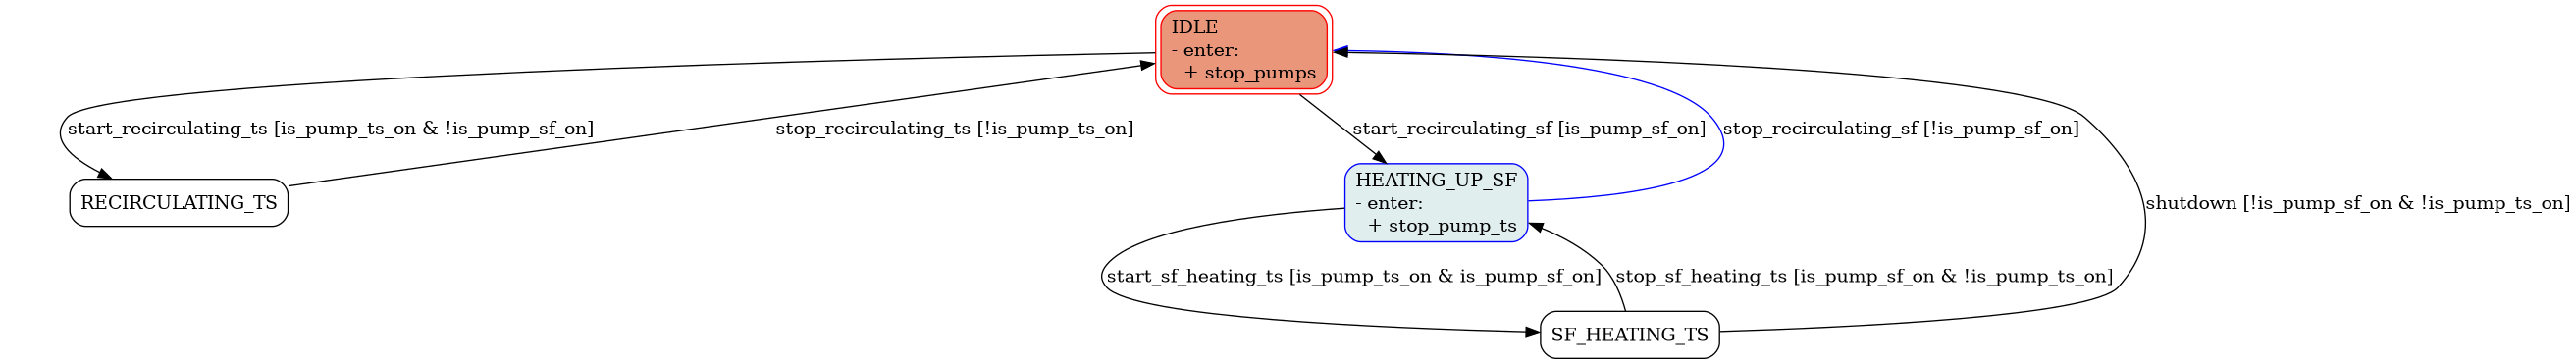

In [4]:
# Test case

model = SolarFieldWithThermalStorage_FSM()

# Go from IDLE to RECIRCULATING_TS
model.step(Tsf_out=0, qts_src=1)
test_state('RECIRCULATING_TS', base_cls=SF_TS_State, model=model)

# Go from RECIRCULATING_TS to HEATING_UP_SF, should raise tr.MachineError
machine_error_raised = False
try:
    model.step(Tsf_out=1, qts_src=1)
except tr.MachineError as e:
    logger.info(f"Expected error: {e}")
    machine_error_raised = True
assert machine_error_raised, "Expected tr.MachineError, got none"

# Go from RECIRCULATING_TS to IDLE
model.step(Tsf_out=0, qts_src=0)
test_state('IDLE', base_cls=SF_TS_State, model=model)

# Go from IDLE to HEATING_UP_SF
model.step(Tsf_out=1, qts_src=0)
test_state('HEATING_UP_SF', base_cls=SF_TS_State, model=model)

# Go from HEATING_UP_SF to SF_HEATING_TS
model.step(Tsf_out=1, qts_src=1)
test_state('SF_HEATING_TS', base_cls=SF_TS_State, model=model)

# Go from SF_HEATING_TS to IDLE
model.step(Tsf_out=0, qts_src=0)
test_state('IDLE', base_cls=SF_TS_State, model=model)

# Go from IDLE to SF_HEATING_TS
while model.state != SF_TS_State.SF_HEATING_TS:
    model.step(Tsf_out=1, qts_src=1)
    time.sleep(1)
        
# Go from SF_HEATING_TS to HEATING_UP_SF
model.step(Tsf_out=1, qts_src=0)
test_state('HEATING_UP_SF', base_cls=SF_TS_State, model=model)

# Go from HEATING_UP_SF to IDLE
model.step(Tsf_out=0, qts_src=0)
test_state('IDLE', base_cls=SF_TS_State, model=model)

result = model.get_graph().draw(None, format="png", prog='dot'); display(Image(result))


## Solar MED FSM

In [3]:
from models_psa.fsms import SolarFieldWithThermalStorage_FSM, MedFSM
from models_psa import SF_TS_State, MedState, SolarMED_State, MedVacuumState

class SolarMED:
    """

    This class is a template for the one in models_psa. 
    It should act like a wrapper around the two individual finite state machines (fsm), and depending on the inputs given to the step method, call the correct events in the individual fsms. It should also provide utility methods like getting the current state of the system, information like the number of complete cycles, etc.

    """

    # states: list[Enum] = [state for state in SolarMED_State]
    current_state: SolarMED_State = None

    def __init__(self):
        
        self.sf_ts_fsm: SolarFieldWithThermalStorage_FSM = SolarFieldWithThermalStorage_FSM(name='SolarFieldWithThermalStorage_FSM', initial_state=SF_TS_State.IDLE)
        self.med_fsm: MedFSM = MedFSM(name='MED_FSM', initial_state=MedState.OFF)
        
    def step(
            self,
            # Thermal storage decision variables
            mts_src: float,  
            # Solar field decision variables
            Tsf_out: float,  
            # MED decision variables
            mmed_s, mmed_f, Tmed_s_in, Tmed_c_out, med_vacuum_state: MedVacuumState  | int,  
            # Environment variables
            Tmed_c_in: float, Tamb: float, I: float, wmed_f: float = None,
            # Optional
            msf: float = None, # Optional, to provide the solar field flow rate when starting up (Tsf_out takes priority)
    ):

        # Validation of inputs


        # After the validation, variables are either zero or within the limits (>0),
        # based on this, the step method in the individual state machine are called
        
        self.sf_ts_fsm.step(Tsf_out=Tsf_out, qts_src=mts_src)
        self.med_fsm.step(mmed_s=mmed_s, mmed_f=mmed_f, Tmed_s_in=Tmed_s_in, Tmed_c_out=Tmed_c_out, med_vacuum_state=med_vacuum_state)
        
        
        self.update_current_state()
        logger.info(f"SolarMED current state: {self.current_state}")

        
    def generate_state_code(self, sf_ts_state: SF_TS_State, med_state: MedState):
        return f"{sf_ts_state.value}{med_state.value}"
    
    def get_current_state(self) -> SolarMED_State:
        state_code = self.generate_state_code(self.sf_ts_fsm.state, self.med_fsm.state)
        return SolarMED_State(state_code)
    
    def update_current_state(self) -> None:
        self.current_state = self.get_current_state()
    
    


In [4]:
# Either use the class defined here
# Or import it from the package

from models_psa.fsms import SolarMED

# Also import the test profile

from models_psa.utils.fsms import test_profile

In [15]:
model = SolarMED()

# model.step(
#     # Decision variables that affect SF-TS FSM
#     mts_src=valid_input,
#     Tsf_out=valid_input,
#     
#     # Decision variables that affect MED FSM
#     mmed_s=valid_input,
#     mmed_f=valid_input,
#     Tmed_s_in=valid_input,
#     Tmed_c_out=valid_input,
#     med_vacuum_state=MedVacuumState.HIGH,
#     
#     Tmed_c_in=valid_input,
#     Tamb=valid_input,
#     I=valid_input,
#     wmed_f=valid_input,
# )

test_profile(model, n_of_steps=3)



2024-04-15 15:26:53.356 | DEBUG    | solarMED_optimization.fsm:inform_exit_state:63 - Left state OFF
2024-04-15 15:26:53.357 | INFO     | solarMED_optimization.fsm:set_vacuum_start:352 - Started generating vacuum, it will take 5 samples to complete
2024-04-15 15:26:53.357 | DEBUG    | solarMED_optimization.fsm:inform_enter_state:59 - Entered state GENERATING_VACUUM
2024-04-15 15:26:53.358 | DEBUG    | solarMED_optimization.fsm.utils:advance_st_ts:70 - Step 1 in SF-TS FSM
2024-04-15 15:26:53.358 | DEBUG    | solarMED_optimization.fsm:inform_exit_state:63 - Left state IDLE
2024-04-15 15:26:53.358 | DEBUG    | solarMED_optimization.fsm:inform_enter_state:59 - Entered state HEATING_UP_SF
2024-04-15 15:26:53.359 | DEBUG    | solarMED_optimization.fsm:inform_exit_state:63 - Left state HEATING_UP_SF
2024-04-15 15:26:53.359 | DEBUG    | solarMED_optimization.fsm:inform_enter_state:59 - Entered state SF_HEATING_TS
2024-04-15 15:26:53.359 | INFO     | solarMED_optimization.fsm:get_next_valid_tra